# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [ ]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

## Import initial libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

## Working with Shape File

### Loading Census Tract Shape File¶

In [2]:
from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [3]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

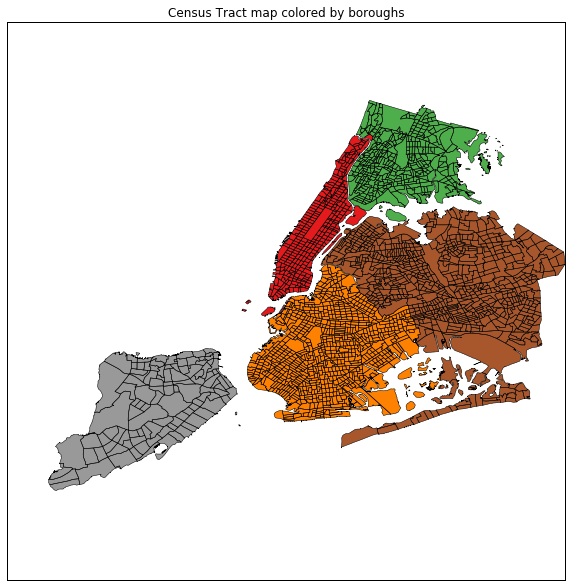

In [4]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [5]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [6]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


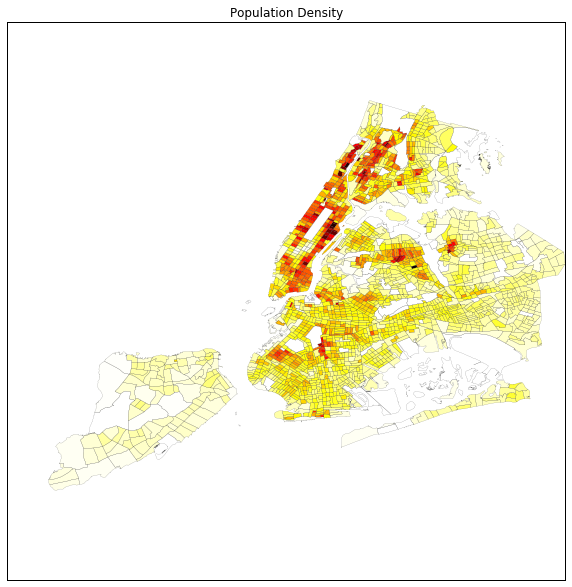

In [7]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [8]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [47]:
df_bike_monthly["month"] = df_bike_monthly.index.month
df_bike_summer = df_bike_monthly[df_bike_monthly["month"].isin([6,7,8])]
df_bike_winter = df_bike_monthly[df_bike_monthly["month"].isin([12,1,2])]

### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

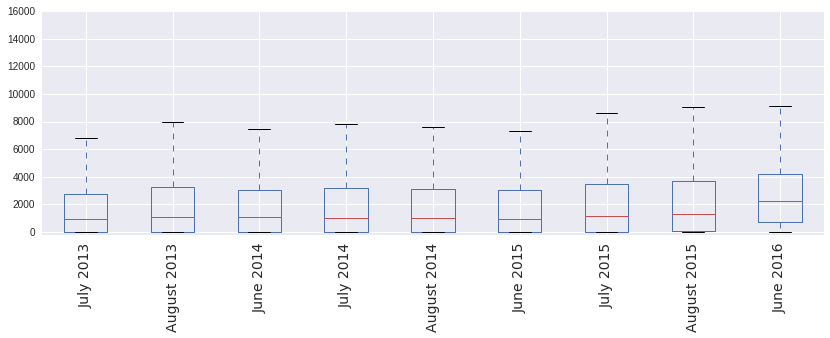

In [48]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_summer_=df_bike_summer.copy()
df_bike_summer_.index=df_bike_summer_.index.strftime("%B %Y")
df_bike_summer_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

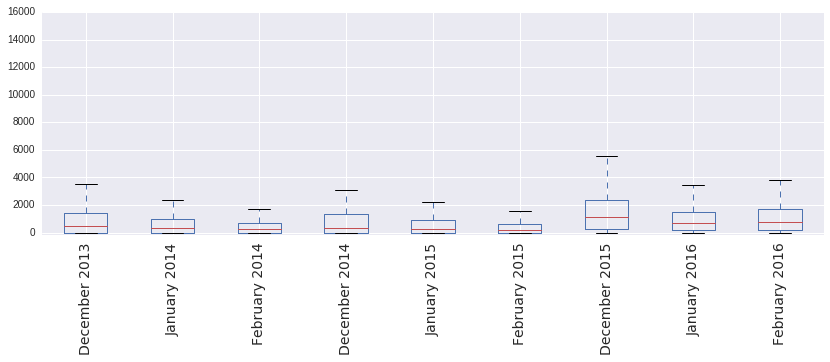

In [49]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_winter_=df_bike_winter.copy()
df_bike_winter_.index=df_bike_winter_.index.strftime("%B %Y")
df_bike_winter_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

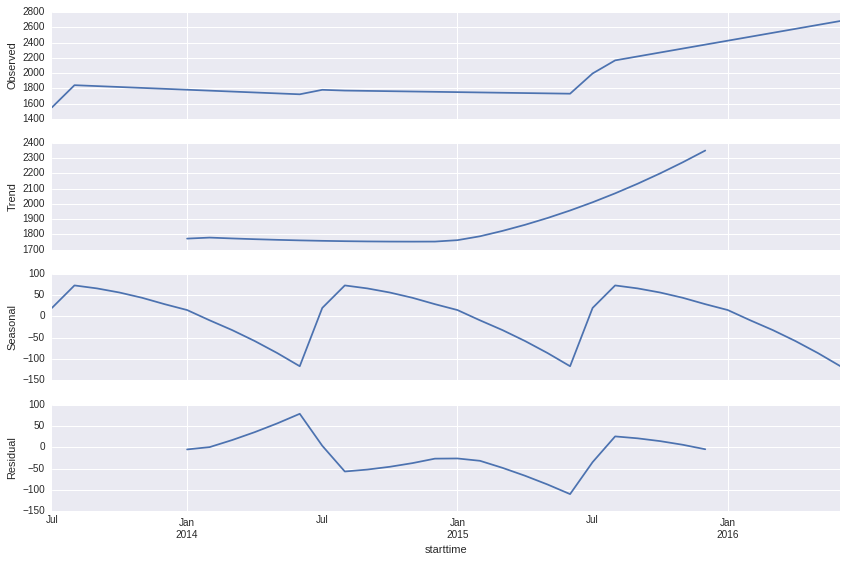

In [50]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new_summer=df_bike_summer.mean(1).resample('M').mean()
df_new_summer.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new_summer.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

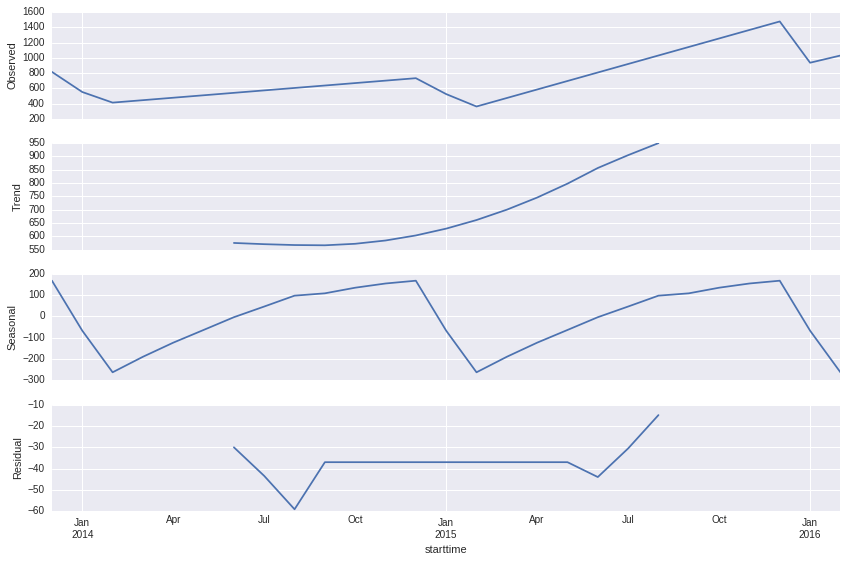

In [51]:
df_new_winter=df_bike_winter.mean(1).resample('M').mean()
df_new_winter.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new_winter.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [11]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [12]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [13]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [14]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [15]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.sum()

In [53]:
station_id_summer = station_id.copy()
station_id_winter = station_id.copy()

In [54]:
station_id_summer['MonthlyAve']=df_bike_summer.sum()
station_id_winter['MonthlyAve']=df_bike_winter.sum()

In [55]:
station_id_summer.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,22422
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,32869
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,87375
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,33018
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,59890


### Add the monthly average rides to the CT shapefile 

In [56]:
# use the 
temp=station_id_summer[['MonthlyAve']]
temp['station_id']=station_id_summer.index
temp.index=station_id_summer['BoroCT2010']
ct_shape_MonthlyAve_summer=ct_shape.join(temp)
ct_shape_MonthlyAve_summer.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [57]:
temp=station_id_winter[['MonthlyAve']]
temp['station_id']=station_id_winter.index
temp.index=station_id_winter['BoroCT2010']
ct_shape_MonthlyAve_winter=ct_shape.join(temp)
ct_shape_MonthlyAve_winter.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


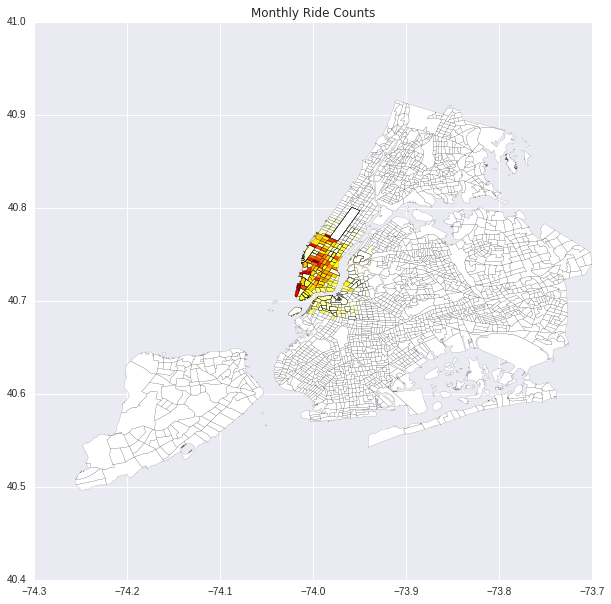

In [58]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_summer.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

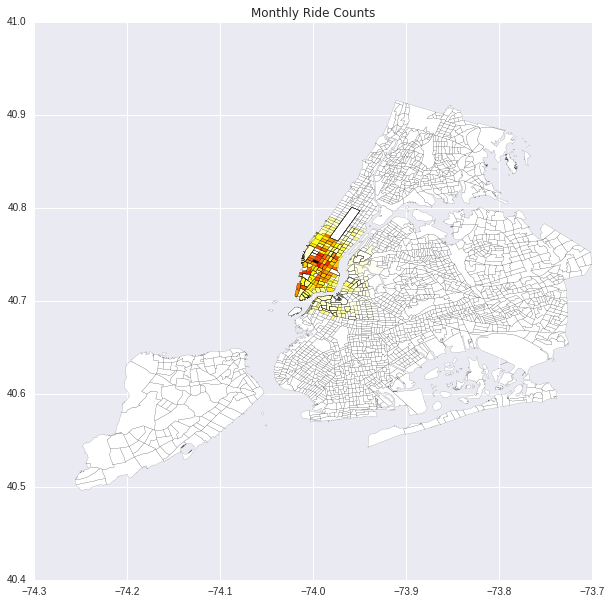

In [59]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_winter.plot(column='MonthlyAve',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

### Removing the CTs that are out of zoom boundries

In [61]:
ct_shape_MonthlyAve_Zoom_summer=(ct_shape_MonthlyAve_summer[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [60]:
ct_shape_MonthlyAve_Zoom_winter=(ct_shape_MonthlyAve_winter[ct_shape_MonthlyAve_winter.centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [62]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

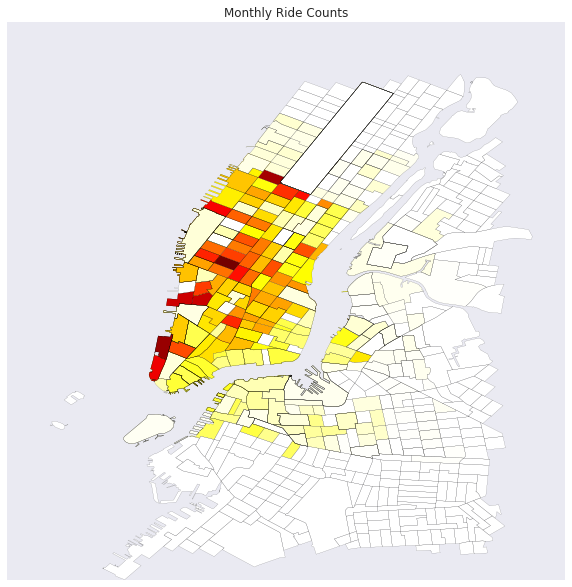

In [63]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom_summer.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

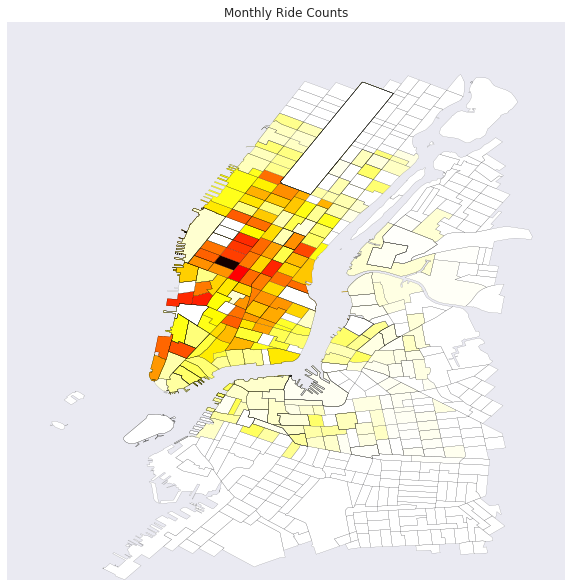

In [64]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom_winter.plot(column='MonthlyAve',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

### Export Shapefile CTs in the CitiBike Zone

In [65]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [66]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [69]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [67]:
qW_CT[10]

{1: 0.1111111111111111,
 8: 0.1111111111111111,
 9: 0.1111111111111111,
 18: 0.1111111111111111,
 19: 0.1111111111111111,
 30: 0.1111111111111111,
 37: 0.1111111111111111,
 38: 0.1111111111111111,
 39: 0.1111111111111111}

In [68]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [27]:
Wmatrix, ids = qW_CT.full()

In [28]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [70]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [72]:
MonthlyRide_summer=ct_shape_MonthlyAve_Zoom_summer.MonthlyAve
MonthlyRideLag_summer=ps.lag_spatial(qW_CT, MonthlyRide_summer)

In [73]:
MonthlyRide_winter=ct_shape_MonthlyAve_Zoom_winter.MonthlyAve
MonthlyRideLag_winter=ps.lag_spatial(qW_CT, MonthlyRide_winter)

#### Create Quantiles for maping

In [74]:
MonthlyRideLagQ10_summer = ps.Quantiles(MonthlyRideLag_summer, k=10)
MonthlyRideLagQ10_summer

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    49.286                 2
   49.286 < x[i] <=   882.900                78
  882.900 < x[i] <=  2346.833                80
 2346.833 < x[i] <=  5645.067                84
 5645.067 < x[i] <=  8593.933                75
 8593.933 < x[i] <= 19189.030                79
19189.030 < x[i] <= 27831.071                80
27831.071 < x[i] <= 32327.735                79
32327.735 < x[i] <= 49147.643                80

In [75]:
MonthlyRideLagQ10_winter = ps.Quantiles(MonthlyRideLag_winter, k=10)
MonthlyRideLagQ10_winter

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    36.286                 2
   36.286 < x[i] <=   603.729                78
  603.729 < x[i] <=  1458.923                80
 1458.923 < x[i] <=  2284.227                79
 2284.227 < x[i] <=  3278.714                80
 3278.714 < x[i] <=  7763.237                79
 7763.237 < x[i] <= 10456.870                80
10456.870 < x[i] <= 12783.385                79
12783.385 < x[i] <= 20551.286                80

#### Map the monthly rides lag

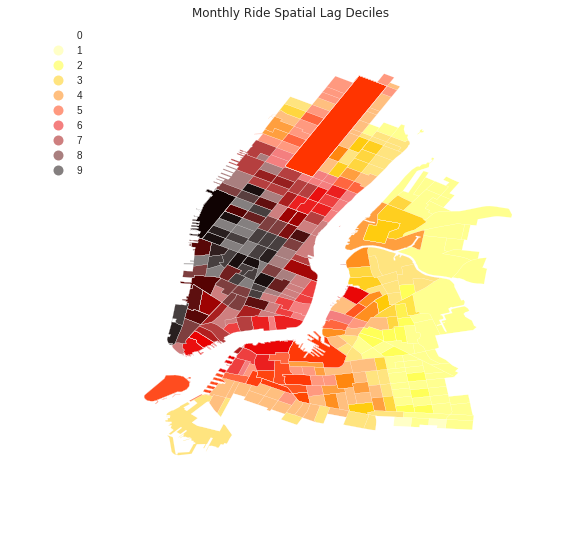

In [78]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom_summer.assign(cl=MonthlyRideLagQ10_summer.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles")


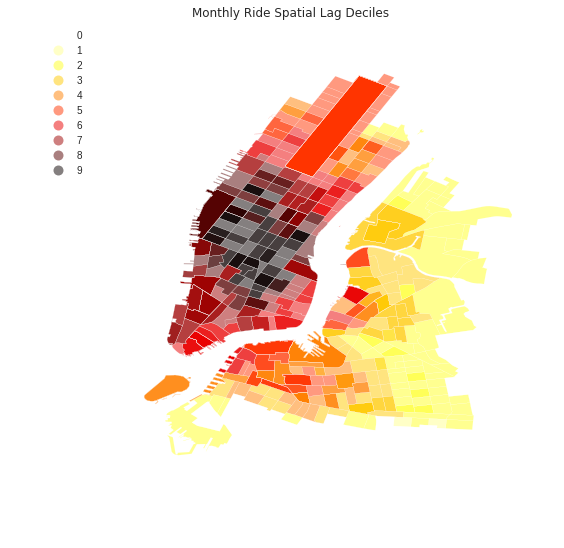

In [77]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom_winter.assign(cl=MonthlyRideLagQ10_winter.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles")

## Global  Spatial Autocorrelation

In [79]:
b,a = np.polyfit(MonthlyRide_summer, MonthlyRideLag_summer, 1)
b,a 

(0.64335490815356511, 4220.5552980795601)

In [80]:
b,a = np.polyfit(MonthlyRide_winter, MonthlyRideLag_winter, 1)
b,a 

(0.66023249858156818, 1600.8324238675889)

### Moran Scatterplot

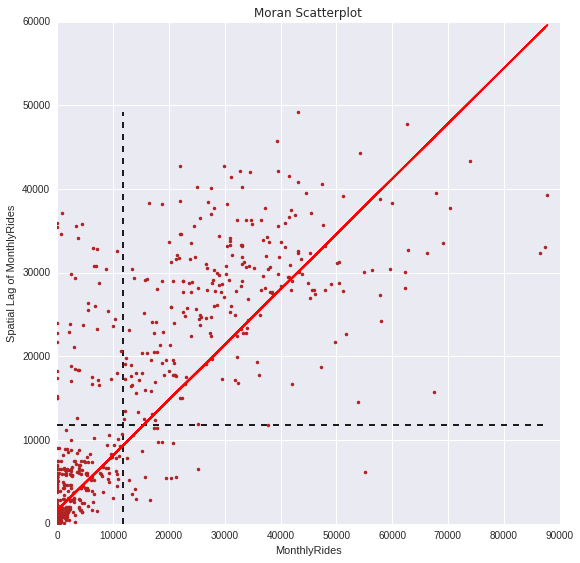

In [83]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_summer, MonthlyRideLag_summer, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_summer, a + b*MonthlyRide_summer, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

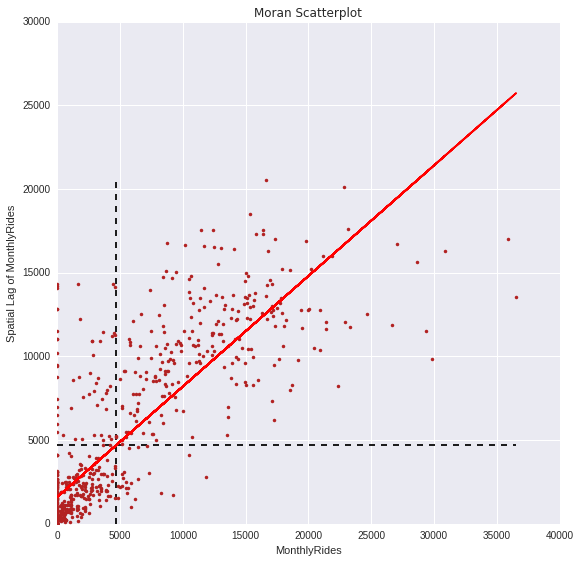

In [84]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_winter, MonthlyRideLag_winter, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_winter, a + b*MonthlyRide_winter, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

### Moran's I

In [85]:
I_MonthlyRide_summer = ps.Moran(MonthlyRide_summer, qW_CT)

In [86]:
I_MonthlyRide_winter = ps.Moran(MonthlyRide_winter, qW_CT)

In [87]:
I_MonthlyRide_summer.I, I_MonthlyRide_summer.p_sim

(0.64353398667011008, 0.001)

In [88]:
I_MonthlyRide_winter.I, I_MonthlyRide_winter.p_sim

(0.66039156431885593, 0.001)

Thus, the $I$ statistic is $0.644$ for this data, and has a very small $p$ value. 

In [89]:
I_MonthlyRide_summer.sim[0:10]

array([-0.00321221,  0.00855876,  0.00621795, -0.01971846, -0.00176735,
       -0.0133505 ,  0.0064714 ,  0.00988   , -0.00047069,  0.02855711])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [38]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

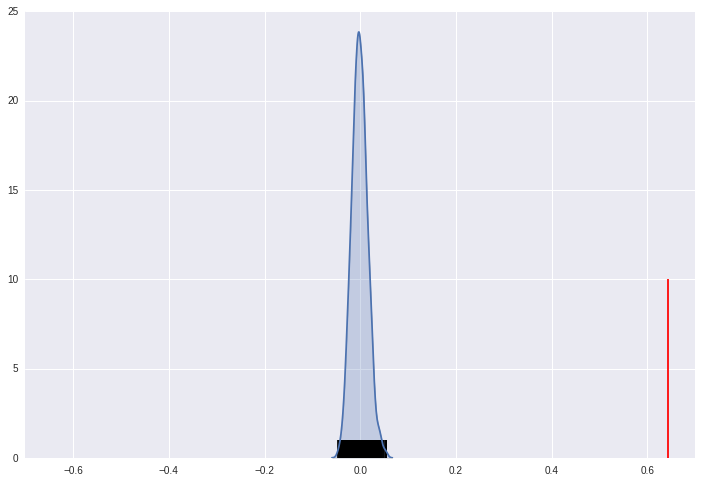

In [90]:
sns.kdeplot(I_MonthlyRide_summer.sim, shade=True)
plt.vlines(I_MonthlyRide_summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_summer.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

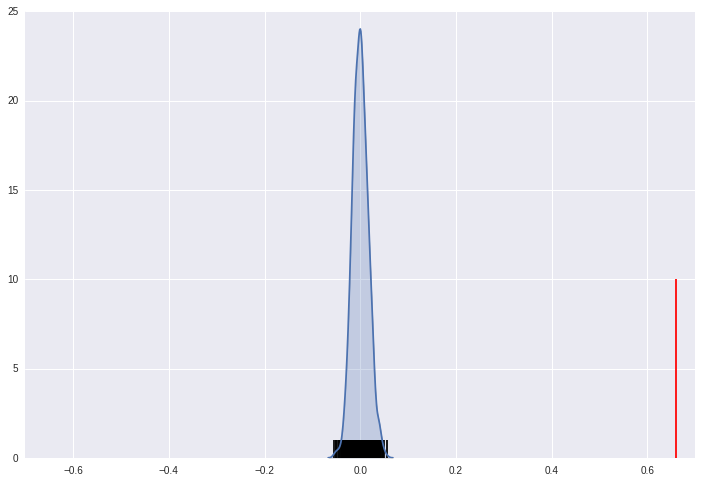

In [93]:
sns.kdeplot(I_MonthlyRide_winter.sim, shade=True)
plt.vlines(I_MonthlyRide_winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_winter.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

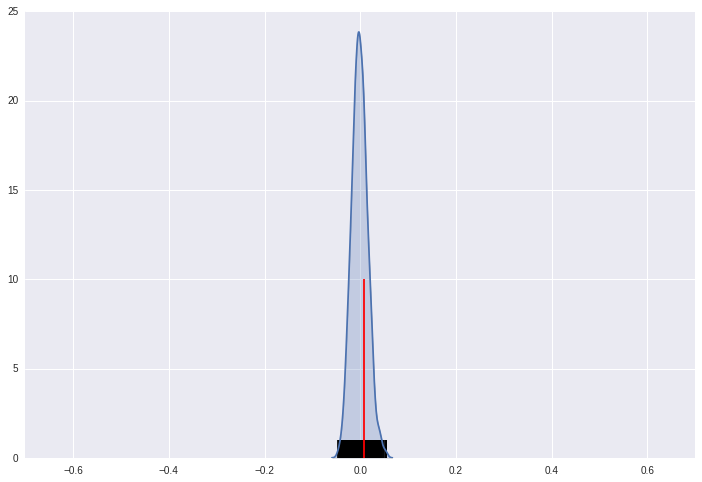

In [92]:
sns.kdeplot(I_MonthlyRide_summer.sim, shade=True)
plt.vlines(I_MonthlyRide_summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_summer.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

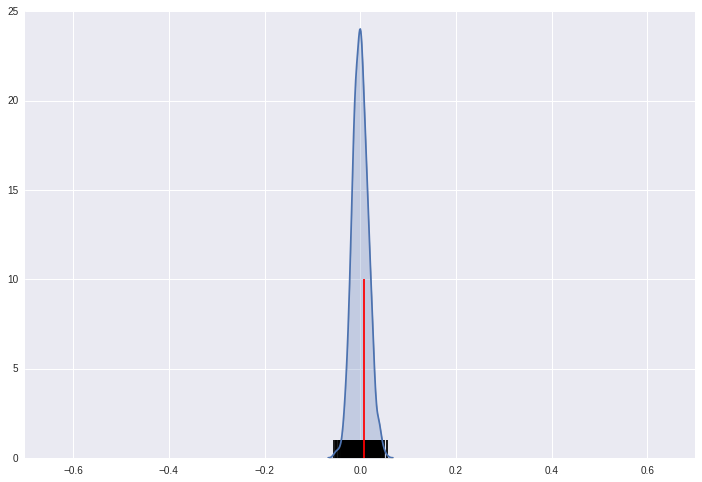

In [91]:
sns.kdeplot(I_MonthlyRide_winter.sim, shade=True)
plt.vlines(I_MonthlyRide_winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_winter.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [94]:
LMo_MonthlyRide_summer = ps.Moran_Local(MonthlyRide_summer, qW_CT,permutations=999)

In [95]:
LMo_MonthlyRide_winter = ps.Moran_Local(MonthlyRide_winter, qW_CT,permutations=999)

In [96]:
LMo_MonthlyRide_summer.Is[0:5], LMo_MonthlyRide_summer.p_sim[0:5]

(array([-0.        , -0.2391325 ,  0.01474643,  0.00173718,  0.02473794]),
 array([ 0.001,  0.173,  0.362,  0.344,  0.368]))

In [97]:
LMo_MonthlyRide_winter.Is[0:5], LMo_MonthlyRide_winter.p_sim[0:5]

(array([ -0.00000000e+00,  -3.14119985e-01,  -1.93084894e-04,
         -4.03594530e-03,  -7.97531288e-02]),
 array([ 0.001,  0.123,  0.499,  0.5  ,  0.386]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [98]:
sigs_s = MonthlyRide_summer[LMo_MonthlyRide_summer.p_sim <= .001]
W_sigs_s = MonthlyRideLag_summer[LMo_MonthlyRide_summer.p_sim <= .001]
insigs_s = MonthlyRide_summer[LMo_MonthlyRide_summer.p_sim > .001]
W_insigs_s = MonthlyRideLag_summer[LMo_MonthlyRide_summer.p_sim > .001]

In [99]:
sigs_w = MonthlyRide_winter[LMo_MonthlyRide_winter.p_sim <= .001]
W_sigs_w = MonthlyRideLag_winter[LMo_MonthlyRide_winter.p_sim <= .001]
insigs_w = MonthlyRide_winter[LMo_MonthlyRide_winter.p_sim > .001]
W_insigs_w = MonthlyRideLag_winter[LMo_MonthlyRide_winter.p_sim > .001]

### Plot Signficant LISA

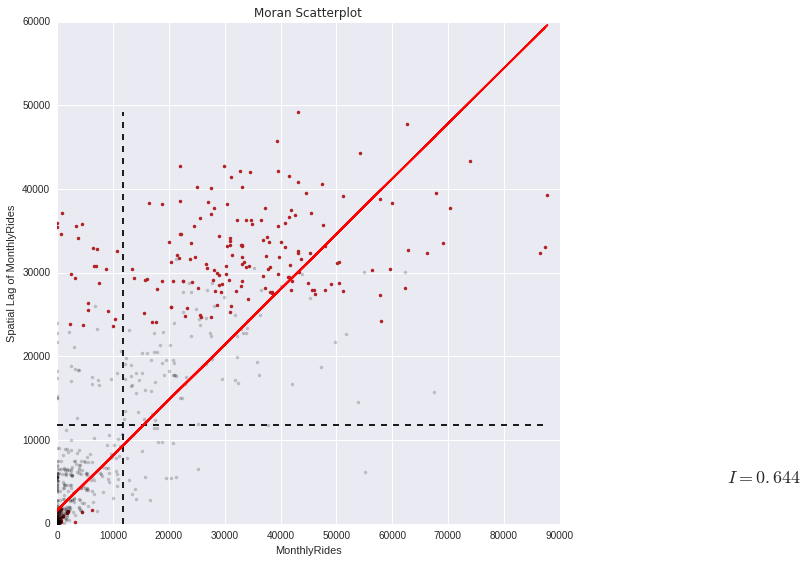

In [101]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_s, W_sigs_s, '.', color='firebrick')
plt.plot(insigs_s, W_insigs_s, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_summer.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_summer, a + b*MonthlyRide_summer, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')


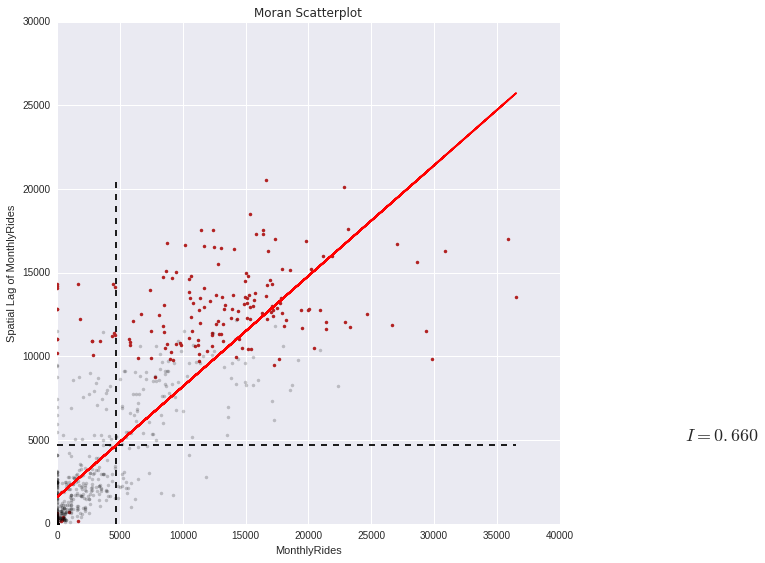

In [102]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_w, W_sigs_w, '.', color='firebrick')
plt.plot(insigs_w, W_insigs_w, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_winter.I, x=50000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_winter, a + b*MonthlyRide_winter, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

### Hot and Cold spots 

In [105]:
sig_s = LMo_MonthlyRide_summer.p_sim < 0.01
hotspots_s = LMo_MonthlyRide_summer.q==1 * sig_s
coldspots_s = LMo_MonthlyRide_summer.q==3 * sig_s
print "Number of Hotspots_s:", hotspots_s.sum()
print "Number of Coldspots_s:", coldspots_s.sum()

Number of Hotspots_s: 188
Number of Coldspots_s: 238


In [107]:
sig_w = LMo_MonthlyRide_winter.p_sim < 0.01
hotspots_w = LMo_MonthlyRide_winter.q==1 * sig_w
coldspots_w = LMo_MonthlyRide_winter.q==3 * sig_w
print "Number of Hotspots_w:", hotspots_w.sum()
print "Number of Coldspots_w:", coldspots_w.sum()


Number of Hotspots_w: 192
Number of Coldspots_w: 211


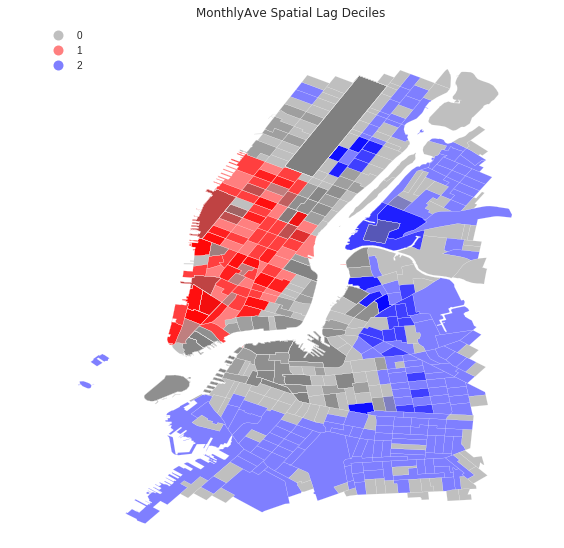

In [108]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots_s*1 + coldspots_s*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom_summer.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")

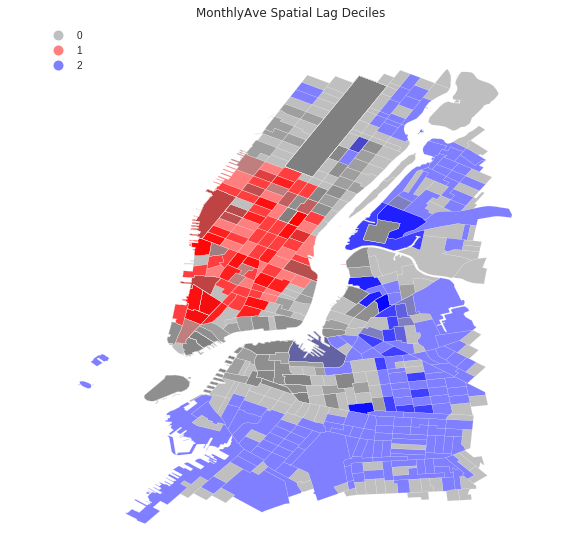

In [109]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots_w*1 + coldspots_w*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom_winter.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")